# Phase 1 - Preliminary Design using Lower Trestles Beach

## **Possible Detection Directions**

### 1. For MVP / Prototype → Blob Detection: Image Processing / Classical CV (Non-Learning)
- No training or learning involved
- Based on pixel-level operations (thresholding, contours, morphology)
- Fast and lightweight
- Not robust to lighting changes, glare, ocean textures, etc.

### 2. For Performance Boost → YOLO: Deep Learning for Object Detection
- Fully deep learning-based
- Uses CNNs to learn features like shape, texture, and spatial context
- Predicts **bounding boxes** and **class labels** in a single forward pass
- Good balance of speed and accuracy
- Other object detection models include **Faster R-CNN**, **SSD**, and **DETR**

### 3. For Final Robust Model → Semantic Segmentation: Deep Learning-Based Computer Vision
- Deep learning models like **DeepLabV3**, **UNet**, **SegFormer**, **Mask R-CNN** (for instance segmentation)
- Outputs a **pixel-level classification map** (each pixel labeled as background, surfer, etc.)
- Requires training on labeled datasets (pixel-wise masks)
- Handles overlapping surfers and varying scales better than bounding box methods

> 🔹 *Note:* Classical (non-deep-learning) segmentation exists (e.g., watershed, region growing), but is not used in this pipeline due to limited robustness and lack of learning capabilities.

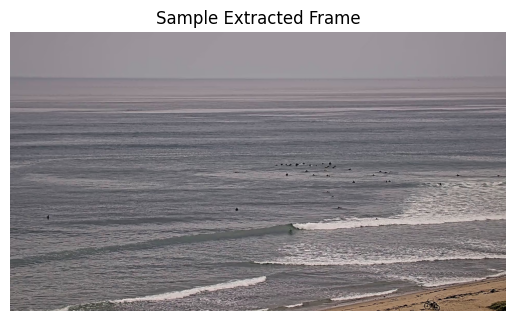

In [1]:
import cv2
import matplotlib.pyplot as plt

img_path = "../Data/frames/frame_0000.jpg"  # Adjust frame number as needed

image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Sample Extracted Frame")
plt.axis('off')
plt.show()

---

## YOLO


image 1/1 c:\Users\chris\Desktop\SCHOOL\24-25\Spring\ECE 140B\SurfWatch\Phase 1-Prelim Design\..\Data\frames\frame_0000.jpg: 384x640 2 persons, 91.5ms
Speed: 3.2ms preprocess, 91.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


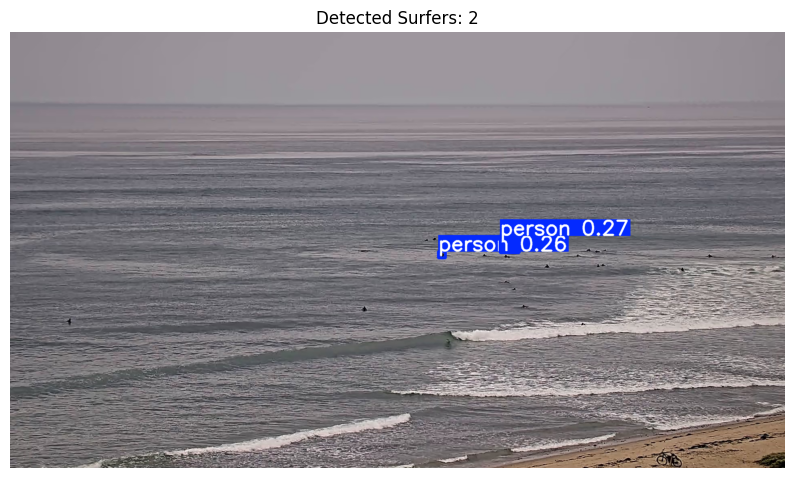

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==== Load YOLOv8 model ====
model = YOLO('yolov8n.pt')  # Replace with your fine-tuned weights if available

# ==== Set frame path ====
frames_dir = "../Data/frames"
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".jpg")])

# ==== Inference on a sample frame ====
frame_index = 0  # Change this to test other frames
frame_path = os.path.join(frames_dir, frame_files[frame_index])
image = cv2.imread(frame_path)

# ==== Run detection ====
results = model(frame_path)  # or model(image) for ndarray

# ==== Parse results ====
surfer_count = 0
for r in results:
    for cls in r.boxes.cls:
        label = model.names[int(cls)]
        if label == "person":  # Adjust if your class is named "surfer"
            surfer_count += 1

# ==== Draw bounding boxes ====
annotated_frame = results[0].plot()  # Draws boxes directly

# ==== Display result ====
annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(annotated_frame_rgb)
plt.title(f"Detected Surfers: {surfer_count}")
plt.axis('off')
plt.show()


--- 

## blob detection with image processing

Estimated surfer count (blob detection): 55


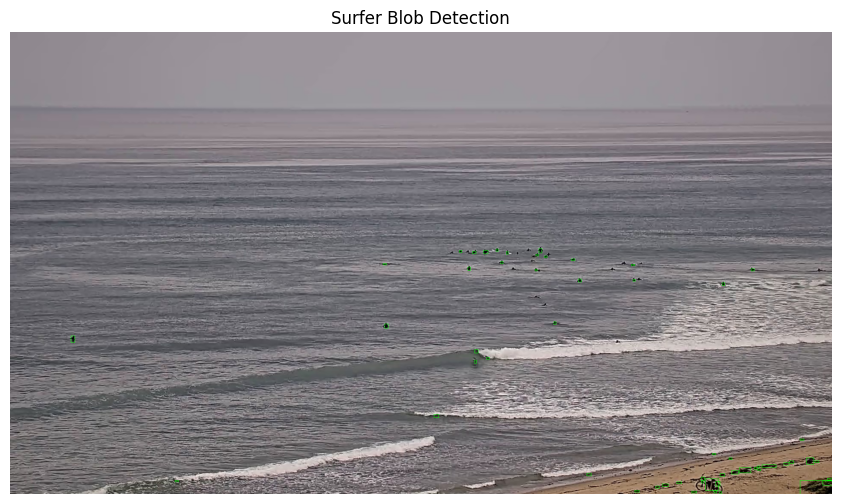

In [1]:
import cv2
import numpy as np

img = cv2.imread("../Data/frames/frame_0000.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold to isolate dark regions (surfers)
_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)

# Morphological operations to remove noise
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# Find contours/blobs
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small blobs
min_area = 10
surfer_blobs = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

print(f"Estimated surfer count (blob detection): {len(surfer_blobs)}")

# Draw results
for cnt in surfer_blobs:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)

# cv2.imshow("Surfer Blobs", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Convert BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(img_rgb)
plt.title("Surfer Blob Detection")
plt.axis("off")
plt.show()

---

## semantic segmentation

In [2]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import os

# Load image
img_path = "../Data/frames/frame_0000.jpg"
img = Image.open(img_path).convert('RGB')

# Define preprocessing transforms
transform = T.Compose([
    T.Resize((520, 520)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Load pre-trained DeepLabv3 model
model = deeplabv3_resnet101(pretrained=True).eval()

# Run inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]
    predicted = output.argmax(0).byte().cpu().numpy()


c:\Users\chris\Desktop\SCHOOL\24-25\Spring\ECE 140B\SurfWatch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chris\Desktop\SCHOOL\24-25\Spring\ECE 140B\SurfWatch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\chris/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:23<00:00, 10.4MB/s] 


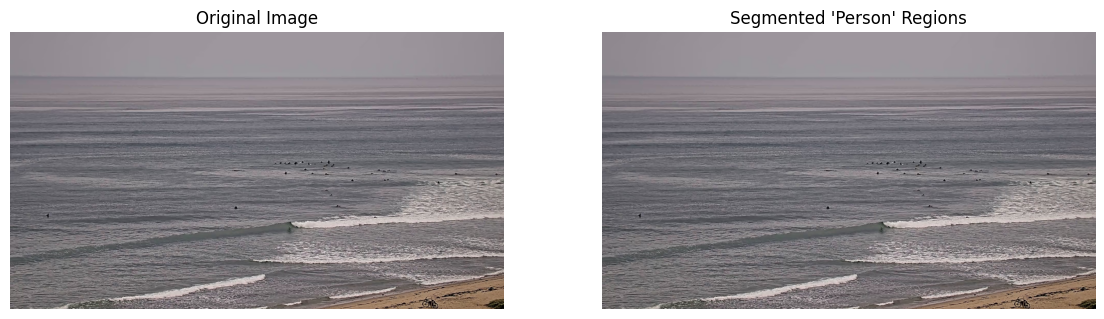

In [3]:
# Define COCO class for 'person'
PERSON_CLASS_ID = 15  # DeepLabV3 with COCO uses 15 for 'person'

# Create binary mask for 'person'
mask = (predicted == PERSON_CLASS_ID).astype(np.uint8) * 255

# Resize to original image size
original_img = np.array(img)
mask_resized = cv2.resize(mask, (original_img.shape[1], original_img.shape[0]))

# Overlay the mask
overlay = original_img.copy()
overlay[mask_resized > 0] = [0, 255, 0]  # Green overlay on detected regions

# Display
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Segmented 'Person' Regions")
plt.axis("off")
plt.show()


In [4]:
# Count distinct blobs in mask (surfers)
contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
surfer_estimate = sum(1 for cnt in contours if cv2.contourArea(cnt) > 30)
print(f"[Segmented Estimate] Surfers detected: {surfer_estimate}")


[Segmented Estimate] Surfers detected: 0
